In [272]:
import sys
oldsysstdout = sys.stdout

from matplotlib import pyplot as plt
%matplotlib inline
from anuga.file import netcdf
import matplotlib.tri as tri
import scipy.interpolate as sp
from glob import glob
import numpy as np

sys.stdout = oldsysstdout
from scipy.signal import savgol_filter as filter



swwFile = 'plane3.sww'



fid = netcdf.NetCDFFile(swwFile)
x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]
conc = fid.variables['concentration'][:]

depth = stage - elev

xmom = fid.variables['xmomentum'][:]
xvel = xmom / (depth + 0.000001)

fid.close()


y2 = (2<y)
y8 = y < 8
indices = y2 * y9

        
triang = tri.Triangulation(x,y)

        
# variables        
g = 9.8
rho_w = 1000.
tau_c = 0.126126
phi = 0.3
vs = 0.0138099680617

Co = 0.005       
Ke = 0.2e-6/(tau_c**0.5)

# d_star
filenames = glob('dstar/dstar*')

ds = np.load(filenames[0])
xx = np.linspace(0.5,14,45)

numbers = []
for f in filenames[1:]:
    a = f.replace('dstar/dstar','')
    b = a.replace('.0.npy','')
    numbers.append(int(b))
    
d_star = np.zeros((len(numbers),len(xx)))


fl = sp.interp1d(x[indices], elev[0][indices], kind='linear')
Dxo = filter(fl(xx), 7, 3)

for i in range(1,len(filenames)):

    ds = np.load(filenames[i])
    fl = sp.interp1d(ds[0], ds[1], kind='linear')
    d_star[i-1] = filter(fl(xx), 7, 3)
    

Cx = np.zeros((len(numbers),len(xx)))
Dx = np.zeros((len(numbers),len(xx)))


for i in numbers:
    
    Co = conc[i][x < 1].max()
    
    j = i - 2

    d_star_u = d_star[j]
    
    fl = sp.interp1d(x[indices], depth[i][indices], kind='linear')
    dxx = filter(fl(xx), 7, 3)
    
    fl = sp.interp1d(x[indices], xmom[i][indices], kind='linear')
    qxx = filter(fl(xx), 7, 3)
    
    
    S = (-np.diff(elev[i][y == 5])/np.diff(x[y ==5]))
    S_ = np.hstack((S,S[-1]))

    fl = sp.interp1d(x[y ==5], S_, kind='linear')
    slope = filter(fl(xx), 7, 3)
    

    u_star = np.sqrt(g * slope * dxx)
    tau = rho_w * u_star**2
    dot_E = Ke * (tau - tau_c)

    Exx = dot_E

    

    Cx[j] = (Co - Exx/(d_star_u * vs)) * np.exp(- d_star_u * vs * xx / qxx) + Exx/(d_star_u * vs)    
 
    Dx[j] = i / (1 - phi) * (d_star_u * vs * Co - Exx) * np.exp(- d_star_u * vs * xx / qxx) + Dxo


# check data

Cx_m = np.zeros((len(numbers),len(xx)))
Dx_m = np.zeros((len(numbers),len(xx)))

for i in numbers:
    
    j = i - 2
    
    fl = sp.interp1d(x[indices], elev[i][indices], kind='linear')
    Dx_m[j] = filter(fl(xx), 7, 3)
    
    fl = sp.interp1d(x[indices], conc[i][indices], kind='linear')
    Cx_m[j] = filter(fl(xx), 7, 3)

    
# root mean square errors

rmse_Cx = np.zeros((len(Cx_m),len(xx)))
rmse_Dx = np.zeros((len(Cx_m),len(xx)))

for i in range(len(Cx_m)):

    rmse_Cx[i] = np.sqrt((Cx_m[i] - Cx[i])**2)
    rmse_Dx[i] = np.sqrt((Dx_m[i] - Dx[i])**2)
    
    
# save outputs

np.save('rmse_concentration.npy', [xx,rmse_Cx])
np.save('rmse_bed.npy', [xx,rmse_Dx])
np.save('analytical_concentration.npy',Cx)
np.save('analytical_bed.npy',Dx)
np.save('model_concentration.npy',Cx)
np.save('model_bed.npy',Cx)

done


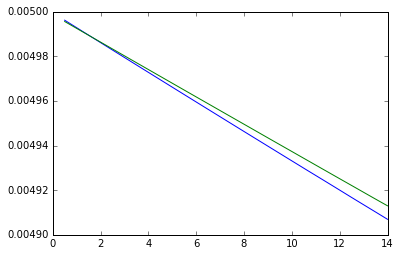

In [273]:
plt.plot(xx, Cx_m[-1],xx, Cx[-1])

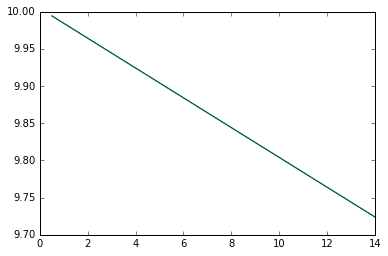

In [274]:
plt.plot(xx, Dx_m[-1],xx, Dx[-1])

In [275]:
rmse_Cx = np.zeros((len(Cx_m),len(xx)))
rmse_Dx = np.zeros((len(Cx_m),len(xx)))

for i in range(len(Cx_m)):

    rmse_Cx[i] = np.sqrt((Cx_m[i] - Cx[i])**2)
    rmse_Dx[i] = np.sqrt((Dx_m[i] - Dx[i])**2)

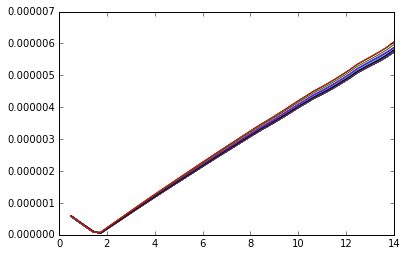

In [281]:
plt.plot(xx,rmse_Cx.T)

In [271]:
rmse

array([[  5.84798536e-07,   4.21121788e-07,   2.61096424e-07, ...,
          5.48599690e-06,   5.62135192e-06,   5.78469280e-06],
       [  5.71980101e-07,   4.08503475e-07,   2.48532591e-07, ...,
          5.50218895e-06,   5.63467167e-06,   5.78884598e-06],
       [  5.75925747e-07,   4.12314555e-07,   2.52426972e-07, ...,
          5.49420931e-06,   5.62689874e-06,   5.78030758e-06],
       ..., 
       [  5.92015966e-07,   4.20876411e-07,   2.53234556e-07, ...,
          5.73062871e-06,   5.87473626e-06,   6.04586686e-06],
       [  5.94034064e-07,   4.22858837e-07,   2.55187862e-07, ...,
          5.73351541e-06,   5.87688646e-06,   6.04446046e-06],
       [  5.95322236e-07,   4.24589520e-07,   2.57065792e-07, ...,
          5.73328248e-06,   5.87560007e-06,   6.04561929e-06]])